# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [7]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

1309
3021
3370
3982
4038
4258
4536
4639
5584


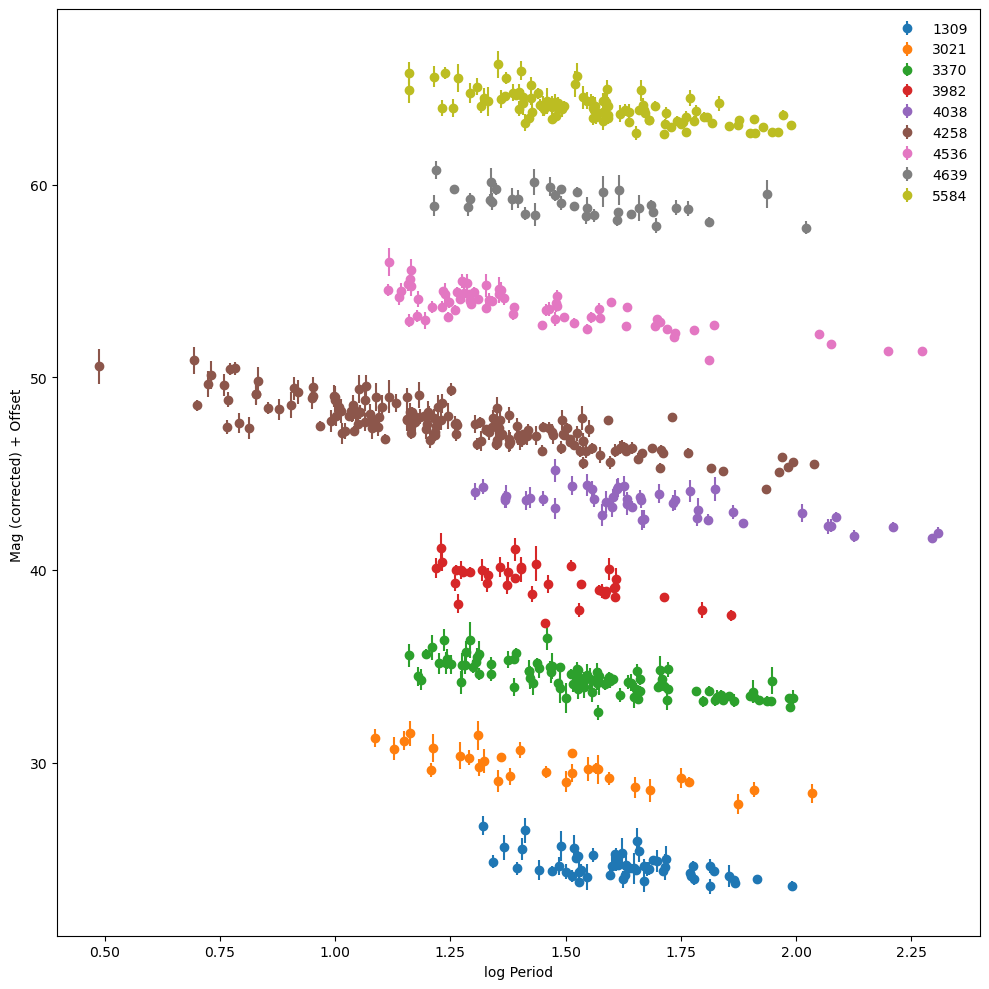

In [12]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    #print(ID)
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


Lets define a new variable for the intercept in our theory calculation for the magnitude

$inter_i = (\mu_{0,i}-\mu_{0,4258})+zp_{W,4258}$

This gives us a theoretical magnitude of 

$m_{W,i,j} = inter_i +b_WlogP_{i,j}$

The likelihood is then

$L = (\prod\limits_{i,j}\frac{1}{\sigma_{int}\sqrt{2\pi}})*exp(-0.5*\sum\limits_{i,j}\frac{(m_{obs,i,j}-m_{W,i,j})^2}{\sigma_{int}^2+\sigma_{mag}^2})$

The log likeihood is

$LogL = const - 0.5*\sum\limits_{i,j}\frac{(m_{obs,i,j}-m_{W,i,j})^2}{{\sigma_{int}^2+\sigma_{mag}^2}}$

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

Given our work in homework 1 the value for $b_W$ is around -3.3. The value should be negative as well so we can set the prior to be a Normal distribution with a mean of -3.3 and a standard deviation of 1. This ensures 99.7% of draws will be negative as the 3 sigma range is from -6.3 to -0.3.

The $inter_i$ parameters will depend on the distances to each galaxy as 

$\mu_{0,i} = 5*log_{10}(\frac{d_i}{10 pc})$

and

$\mu_{0,i} -\mu_{0,4258} = 5*log_{10}(\frac{d_i}{d_{4258}})$

We are given the redshift of the galaxies and we know $z \approx H_0d/c$ for small distances. This means $\frac{d_i}{d_{4258}} = \frac{z_i}{z_{4258}}$. Using this we can make an estimate for $\mu_{0,i} -\mu_{0,4258}$.

Therefore the prior for $inter_i$ will be a normal distribution with a mean of $(\mu_{0,i}-\mu_{0,4258})+zp_{W,4258}$. I'll choose a standard deviation of 1 which seems reasonable as a change of 1 represents a change of 10 in the distance, this can always be changed if needed.

we can get an esitmate for $zp_{W,4258}$ by fitting a line to this galaxy's data. 


In [26]:
import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from scipy import optimize
import pandas as pd
from astropy.table import Table
import scipy.stats
import scipy.optimize as so

redshift_data = np.loadtxt('R11redsh.dat')
#print(redshift_data)
ID_array = redshift_data[:,0]
z_vals = redshift_data[:,1]
#print(z_vals)
z_4258 = z_vals[5]
#print(z_4258)

ceph.select(4258)
mobs = ceph.mobs
logP = ceph.logP
p = np.polyfit(logP, mobs, 1)
#plt.plot(logP, mobs, '.')
#print(p)
zp_4258_est = p[1]
print(zp_4258_est)



inter_est = zp_4258_est + 5*np.log10(z_vals/z_4258)
print('estimated values for inter_i:')
print(inter_est)

26.716415320609364
estimated values for inter_i:
[30.10858668 29.39947793 28.99476659 28.68508399 29.53737604 26.71641532
 29.74660898 28.49886123 29.53221579]


# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [28]:
# Setting up functions for model, prior, postior, likelihood

n_gal = 9
ndim = n_gal+1

# intrinsic scatter is given in this paper
# https://iopscience.iop.org/article/10.3847/0004-637X/826/1/56/pdf
sigma_int = 0.08

#for i, ID in enumerate(hosts):
#    #print(ID)
#    ceph.select(ID)
#    mobs = ceph.mobs
#    logP = ceph.logP
#    sigma_obs = ceph.sigma




# 10 variables: mu_diff_zp (9 for galaxies) - difference between reddening free distance of galaxy and
# NGC4258 plus intercept of NGC4258 P-L relation
# bw - nussiance parameter descibing relation between cephied period and luminosity


def model(theta, P, gal_index):
    bw = theta[0]
    mu_diff_zp = theta[gal_index+1]
    
    m = mu_diff_zp + bw*P
    return m

def chisq(theta, *args):

    P, m_vals, sigma_comb, gal_index = args
    mod = model(theta, P, gal_index)
    chisq = np.sum(((m_vals - mod)**2.)/(sigma_comb**2.))
    return chisq 

#def log_likelihood(theta, P, m_vals, sigma_m):
def log_likelihood(theta, ceph, hosts, sigma_int):
    LogLike = 0
    for i, ID in enumerate(hosts):
        ceph.select(ID)
        mobs = ceph.mobs
        logP = ceph.logP
        sigma_obs = ceph.sigma
        sigma_comb = np.sqrt(sigma_obs**2+sigma_int**2)
        args = (logP, mobs, sigma_comb, i)
        LogLike += -chisq(theta, *args)/2.
    
    return LogLike

def log_prior(theta, ceph, hosts, int_est):
    #pr = 0
    pr = np.log(scipy.stats.norm.pdf(theta[0], loc=-3.3, scale=1.0))
    
    for i, ID in enumerate(hosts):
        pr += np.log(scipy.stats.norm.pdf(theta[i+1], loc=int_est[i], scale=1.0))
    
    return pr

def log_posterior(theta, ceph, hosts, int_est, sigma_int):

    post = log_prior(theta, ceph, hosts, int_est) + log_likelihood(theta, ceph, hosts, sigma_int)
 
    return post

In [35]:
# Run emcee

guess = np.concatenate((np.array([-3.3]),np.array(inter_est)))
#print(guess)

nwalkers = 20
nsteps = 10000

starting_guesses = guess + 1.0*np.random.randn(nwalkers, ndim)
#print(starting_guesses)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[ceph, hosts, inter_est, sigma_int])
_ = sampler.run_mcmc(starting_guesses, nsteps)
samples = sampler.get_chain(flat=True)

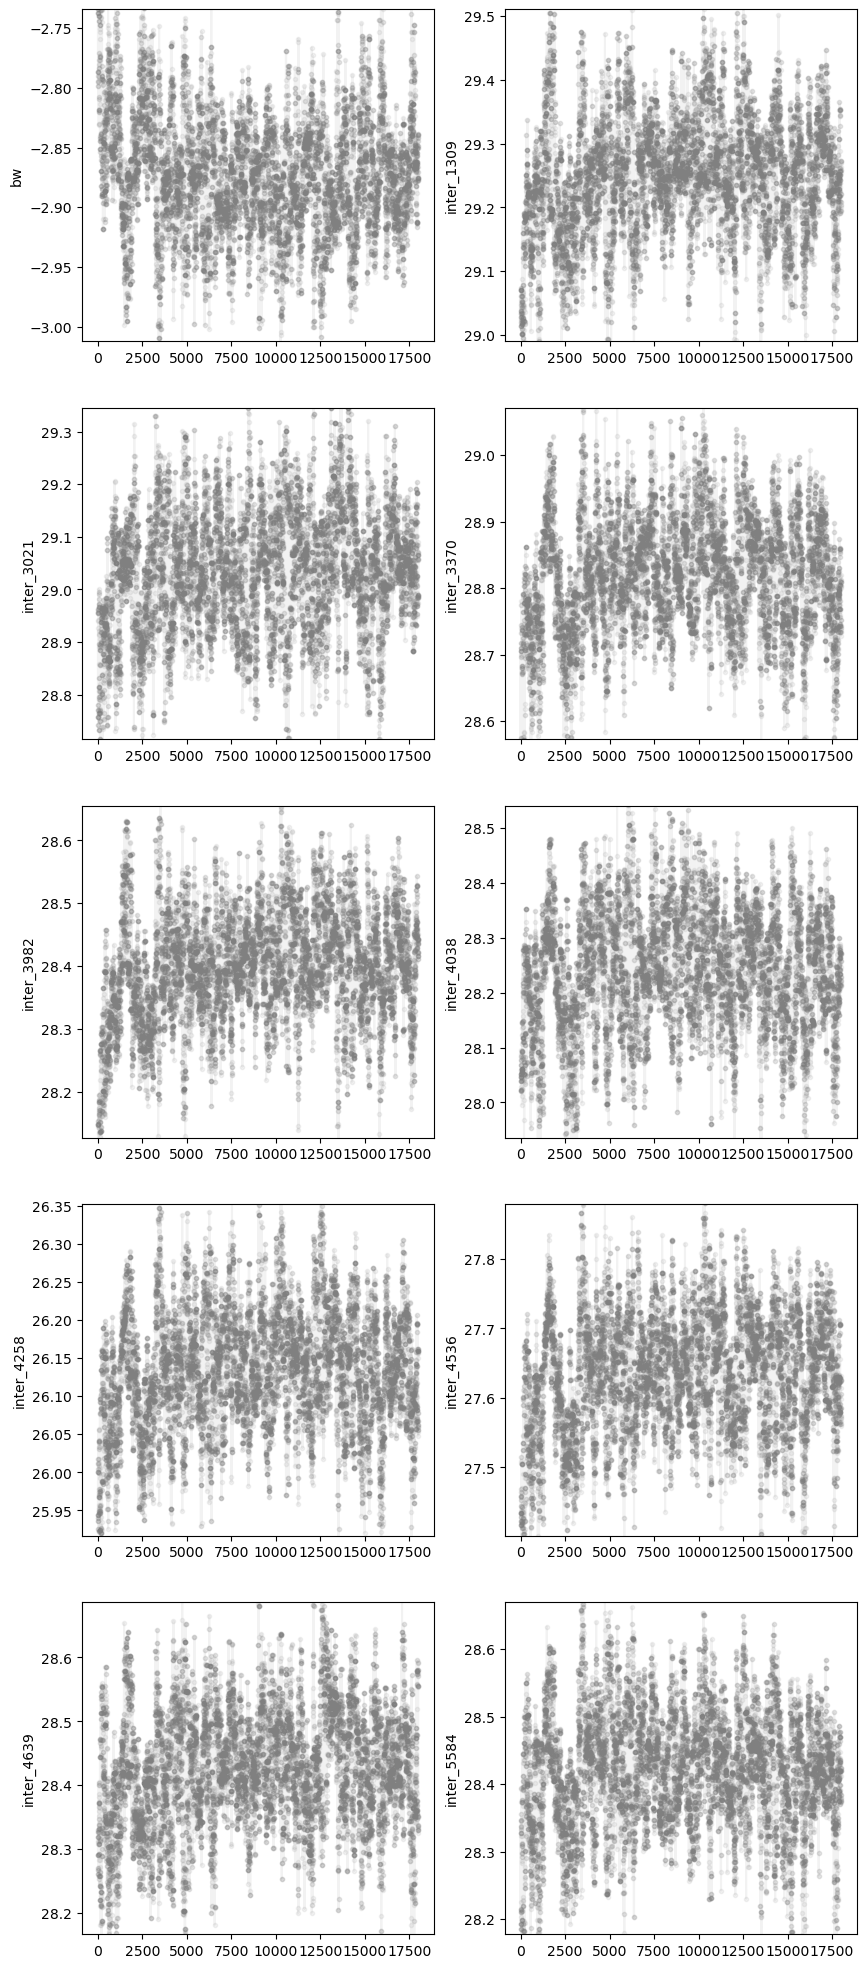

In [46]:
# Plot traces

nburn = 20000
labels=['bw']
for i, ID in enumerate(hosts):
    labels.append('inter_'+str(ID))

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 25))
for i in range(samples.shape[1]):
    j, k = np.unravel_index(i, (5,2))
    ax = axs[j][k]
    ax.plot(samples[nburn::10,i], linestyle='-', color='grey', marker='.', alpha=0.1)
    med = np.median(samples[nburn:,i])
    std = np.std(samples[nburn:,i])
    ax.set_ylim(med-3*std, med+3*std) 
    ax.set_ylabel(labels[i])
fig.savefig('Trace_plots_cepheids.png')



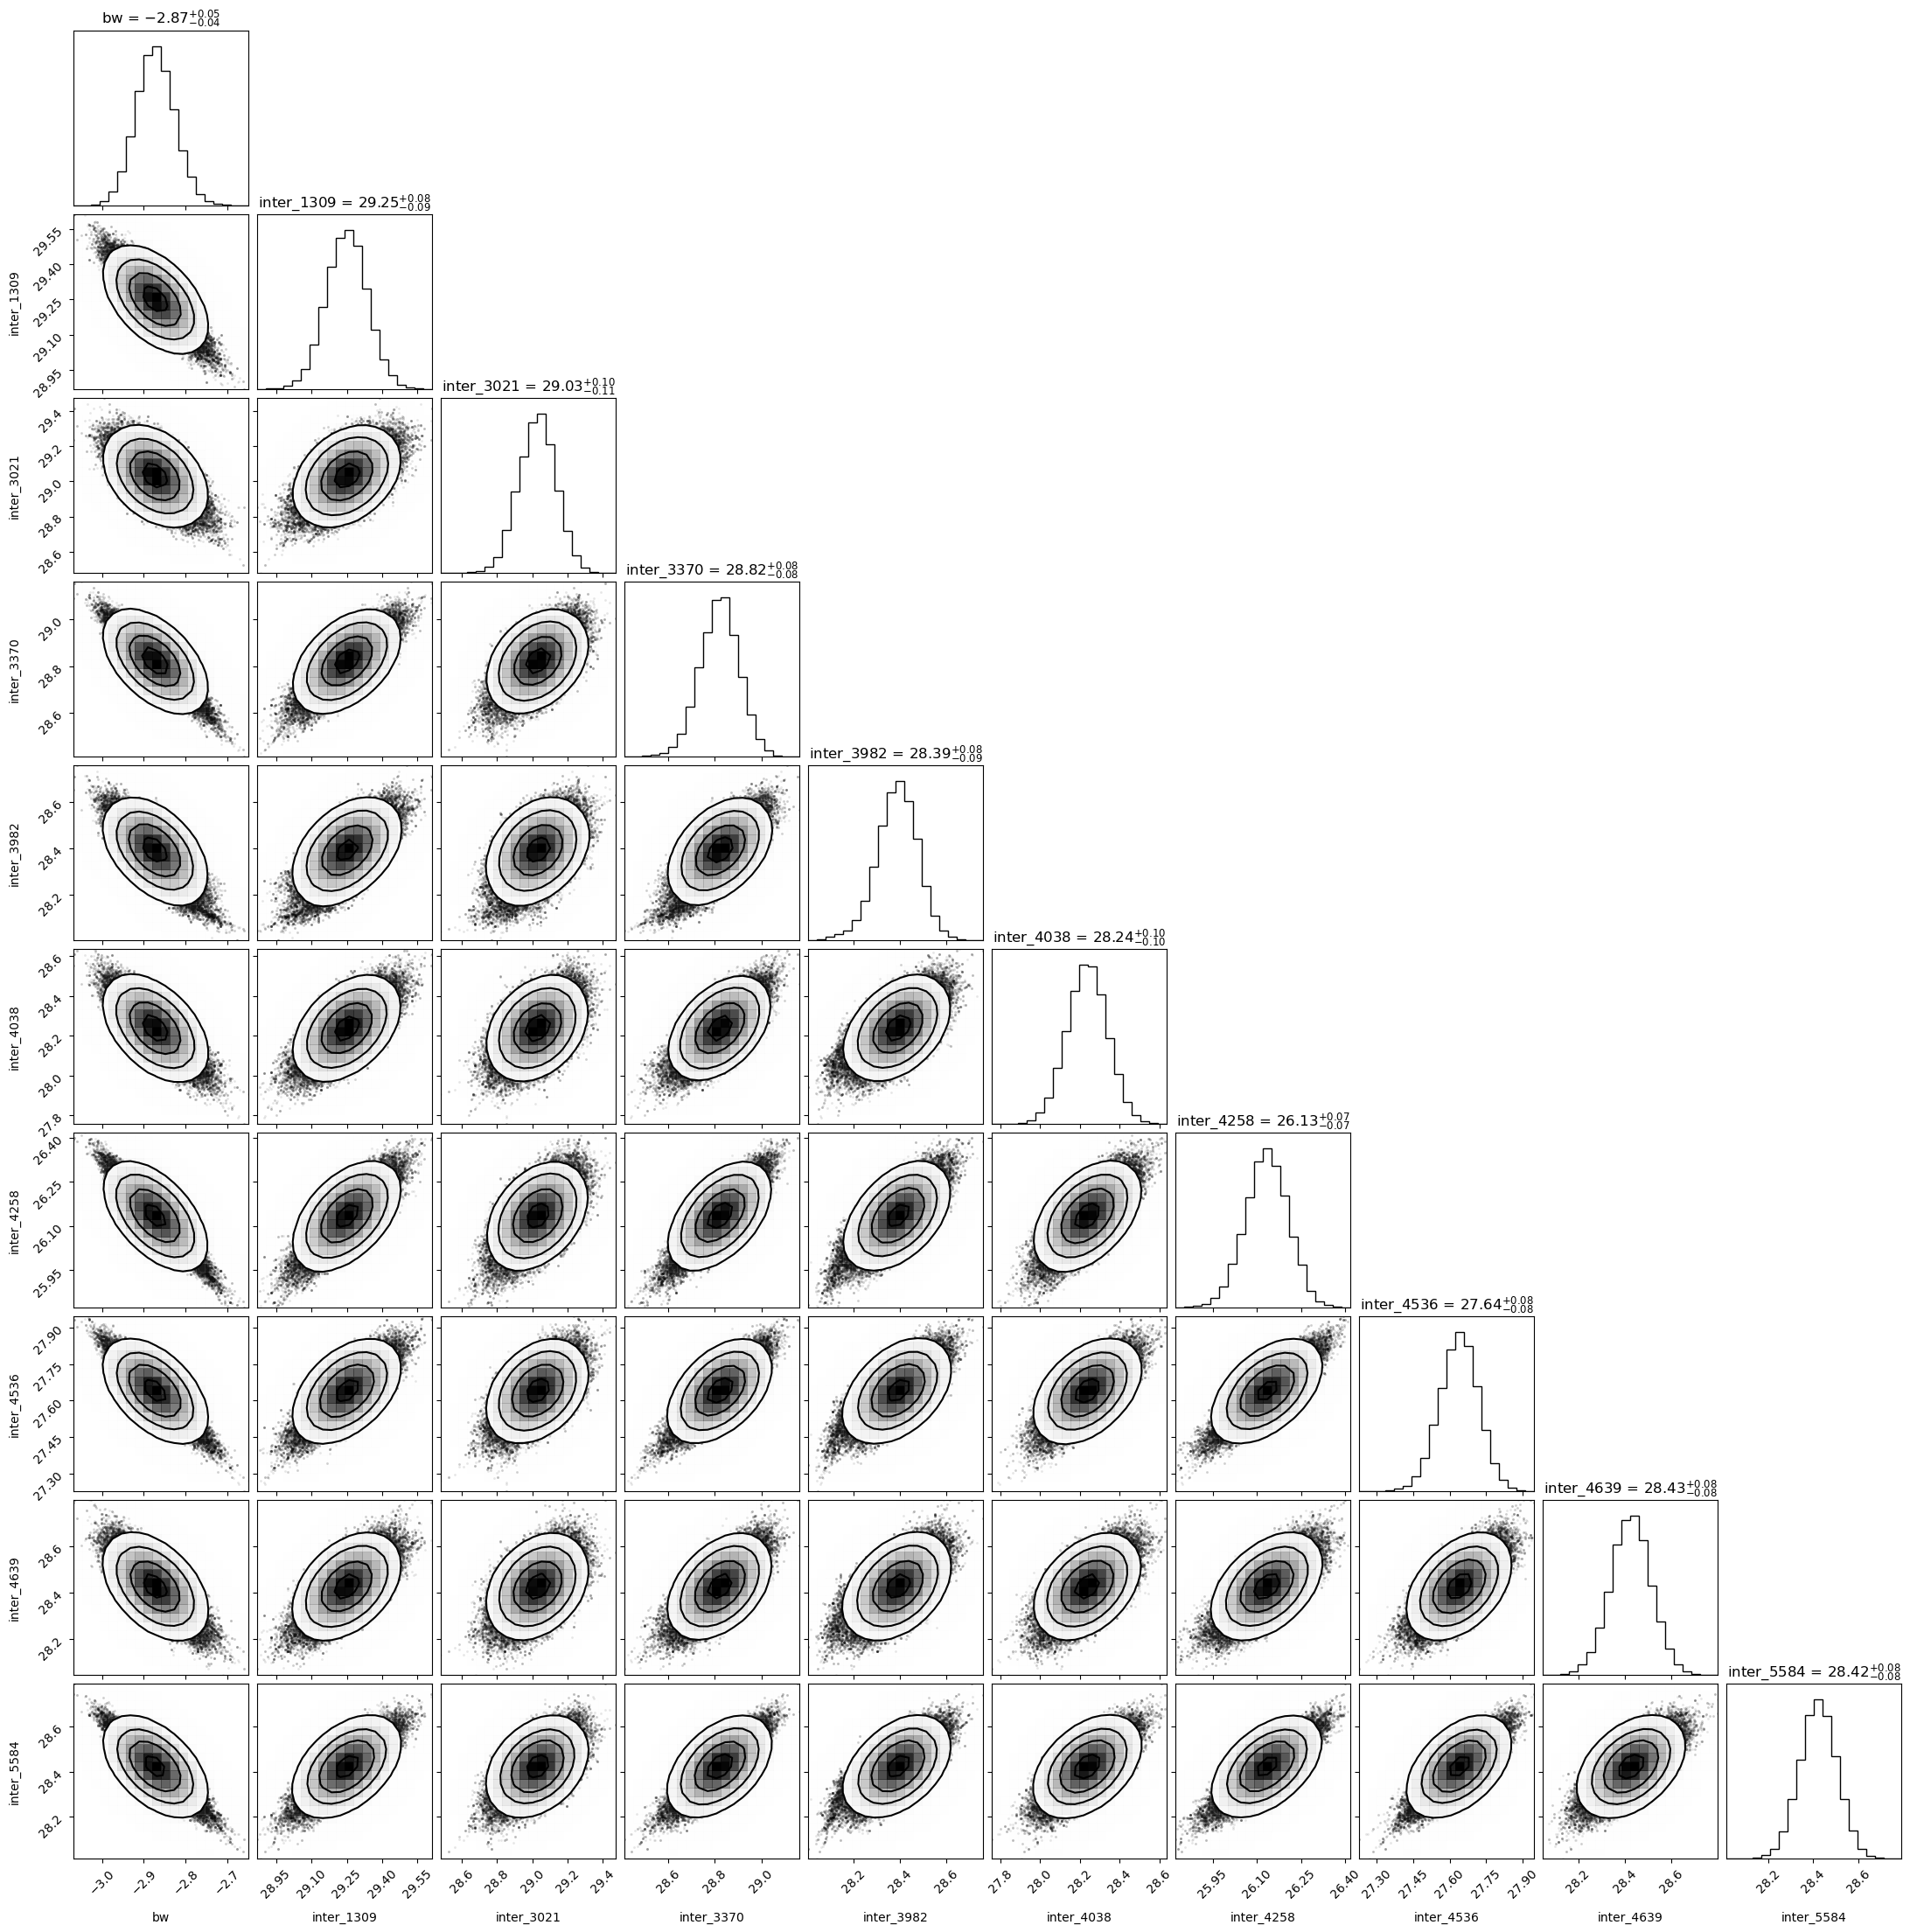

In [47]:
# Corner plots
fig = corner.corner(samples[nburn:,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
fig.savefig('Corner_plot_cepheids.png')

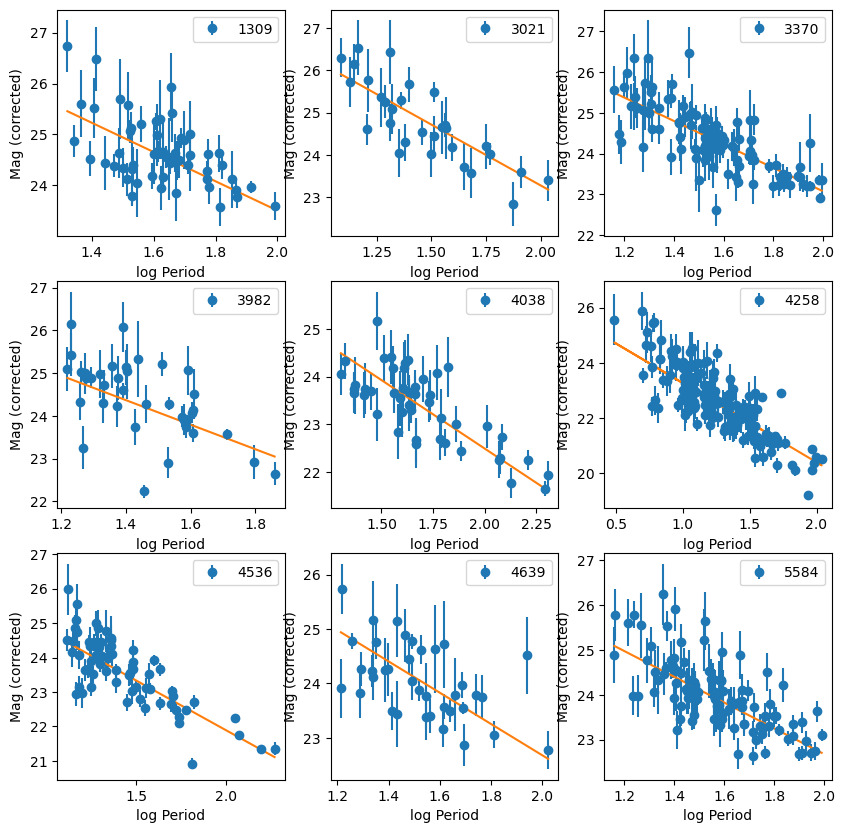

In [81]:
# Recreating figure 7
median_values = [np.median(samples[nburn:,0])]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

for i, ID in enumerate(hosts):
    j, k = np.unravel_index(i, (3,3))
    ax = axs[j][k]
    #print(ID)
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    med = np.median(samples[nburn:,i+1])
    median_values.append(med)
    #print(median_values[0])
    fit_m = logP*median_values[0]+med 
    ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    ax.plot(logP, fit_m)
    ax.legend()
    ax.set_xlabel('log Period')
    ax.set_ylabel('Mag (corrected)')
    #ax.title('n')



In [82]:
# Compare to Table 3


inter_new = median_values[1:] - median_values[6] # need to subtract off zp_4258

#print(inter_new)
print('mu_i - mu_4258 values:')
for i, ID in enumerate(hosts):
    print('n'+str(ID)+': '+str(inter_new[i]))

mu_i - mu_4258 values:
n1309: 3.1161684492905017
n3021: 2.896067774841743
n3370: 2.687754936381989
n3982: 2.2566150226837536
n4038: 2.103869583766656
n4258: 0.0
n4536: 1.5058170392598633
n4639: 2.2921567510847254
n5584: 2.2889363175082984


Comparing these values with Table 3 in the paper my values seem to be within 1-2 sigma of my errorbars in my corner plot.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

$m_{v,4258}^0 = m_{v,i}^0 - (\mu_{0,i} - \mu_{0,4258})$

$log H_{0} = \frac{(m_{v,i}^0 - (\mu_{0,i} - \mu_{0,4258}) - \mu_{0,4258}) + 5a_v+25}{5}$

$log H_{0} = \frac{(m_{v,i}^0 + 5a_v) - (\mu_{0,i} - \mu_{0,4258}) - \mu_{0,4258} +25}{5}$

$(m_{v,i}^0 + 5a_v)$ is given by the table, $(\mu_{0,i} - \mu_{0,4258})$ we have from emcee, $\mu_{0,4258}$ we can get from the paper below

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [83]:
m_5a = np.array([16.768, 16.699, 16.545, 15.953, 15.901, 0, 15.147, 16.040, 16.274])
# doesn't have data for NGC 4258 in table
mask = np.where(m_5a>0)

#distance reported in paper
d_4258 = 7.6*10**6 #pc
mu_4258 = 5*np.log10(d_4258/10)
#print(mu_4258)

#print(mask)
logH = (m_5a[mask] - inter_new[mask] - mu_4258 + 25)/5
H = 10**logH
#print(H)
H_mean = np.mean(H)
H_std = np.std(H)
print('H0 = '+str(round(H_mean,3))+' +- '+str(round(H_std,3))+' km/s/Mpc')

H0 = 74.853 +- 3.753 km/s/Mpc


My value of $H0 = 74.85 \pm 3.75 \frac{km}{s*Mpc}$ is very close to the best estimate value reported in the paper ($H0 = 73.8 \pm 2.4 \frac{km}{s*Mpc}$).